# `Project`: Treasury Bill Pricing, Interest Rate Risk and Term to Maturity
This project, which extends the previous example, familiarizes students with computing the sensitivity of the price of United States Treasury Bills `T-bills` to changes in the interest rate as a function of the duration of the instruments. In particular, Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., Treasury Bills, Notes, and Bonds, as a function of the duration and yield values:

* [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218. https://doi.org/10.2307/1880816](https://www.jstor.org/stable/1880816https://www.jstor.org/stable/1880816)

In this project, you will develop a simulation test of the second of the five theorems:

> __Theorem 2__: For a given change in yield from the nominal yield, changes in bond prices are greater the longer the term to maturity

## Learning objectives
* __Prerequisite__: Before we begin any calculations, we'll load a United States Treasury action dataset for `T-bills` downloaded from [TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/).
* __Objective 1__: First, you'll compute the price of a random `T-bill` and validate your simulated price using Treasury auction data from `2022` and `2023`.
   * `TODO`: Verify the computed price of a random `T-bill` versus the observed auction price using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and the [isapprox(...)](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) function.
* __Objective 2__: Next, you'll compute the sensitivity of short- and long-duration `T-bill` prices to changes in the interest rate. Long-duration `T-bills` should be more sensitive to interest rate changes than shorter-duration instruments.
    * `TODO` Build a short-duration bill model
    * `TODO` Build a long-duration bill model
    * `TODO`: Specify a range of perturbation values for the effective interest rate $\bar{r}$, and compute this array $\beta$
    * `TODO`: Compute the change of the short and long-duration prices as a function of the yield and visualize the percentage change in the price versus the perturbation $\beta$

## Setup
We load the [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) package, and several other external [Julia](https://julialang.org/downloads/https://julialang.org/downloads/) packages, as well as some helper code included in the `src` directory, by calling the [include(...)](https://docs.julialang.org/en/v1/manual/code-loading/https://docs.julialang.org/en/v1/manual/code-loading/) command on the file `Include.jl`.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

##  __Prerequisite__: Load the Treasury Auction Dataset
We'll explore `T-bill` prices from United States Treasury auctions between April 2023 and January 2024 downloaded as a `CSV` file using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). We load the `CSV` dataset using the `MyTreasuryBillDataSet()` function, which returns the auction data as a `DataFrame`:

In [2]:
dataset = MyTreasuryBillDataSet();

Finally, let's set the dimension of our auction dataset in the `number_of_bills` variable:

In [3]:
number_of_bills = nrow(dataset);

## __Objective 1__: Compute and Verify the Price of a Random Treasury Bill
We begin computing the T-bill price by building a discounting model. In this case, let's construct an instance of the `DiscreteCompoundingModel()` type and store this discount model in the `discount_model` variable:

In [4]:
discount_model = DiscreteCompoundingModel();

Next, select a bill from the `dataset`, by randomly selecting an index from `1...number_of_bills` using the [built-in Julia rand function](https://docs.julialang.org/en/v1/stdlib/Random/#Base.rand):

In [5]:
random_bill_index = rand(1:number_of_bills)
println("Selected bill: $(random_bill_index)")

Selected bill: 138


In [6]:
dataset[random_bill_index,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
138,912796CR8,Bill,42-Day,08/08/2023,08/10/2023,09/21/2023,99.3846,0.05396


### `Check`: Verify the computed price of a random `T-bill`
Create an instance of the `MyUSTreasuryZeroCouponBondModel` model, using the `build(...)` method, assuming a par value of `100 USD` and two compounding periods per year. Update the duration `T` and `rate` fields, and use the short-cut syntax to compute the price. Save the updated model in the `zero_coupon_model` variable. 

In [7]:
zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2, 
        
    ### BEGIN SOLUTION    
    T = dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
    rate =  dataset[random_bill_index, Symbol("Investment Rate")]
    ### END SOLUTION    
        
)) |> discount_model;

If the computed and observed price are `different`, i.e., they have relative difference tolerance of `rtol`$>$`1e-4`, then the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) will `fail`, resulting in an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError)

In [8]:
@assert isapprox(zero_coupon_model.price, dataset[random_bill_index,:Price], rtol=1e-4)

## __Objective 2__: Compute the sensitivity of the `T-bill` price to interest rate and term to maturity

Let's test Theorem 2 by simulating prices as a function of interest rate and term to maturity. Create models for two bills $i$ and $j$ from the `dataset`. Bills $i$ and $j$ should have a significant difference in duration, for example, `4 weeks` versus `52 weeks`, and then simulate how these instruments' prices change as we vary the yield by the same percentage. Assume a $V_{P} = 100$ USD for both instruments and semiannual compounding, i.e., $n = 2$.

### `TODO` Build a short-duration bill model
Select the index of a random `4-Week` duration treasury bill, and save this index in the variable `i`:

In [9]:
short_duruation_dataset = filter(Symbol("Security Term") => x-> x == "4-Week", dataset)
i = nrow(short_duruation_dataset) |> x-> rand(1:x);
short_duruation_dataset[i,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
29,912797FZ5,Bill,4-Week,06/22/2023,06/27/2023,07/25/2023,99.6103,0.05113


Build an instance `MyUSTreasuryZeroCouponBondModel` to model the random `4-Week` treasury bill, and compute the price using the short-cut syntax:

In [10]:
short_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    
    ### BEGIN SOLUTION    
    par = 100, n = 2, 
    T = short_duruation_dataset[i, Symbol("Security Term")] |> String |> securityterm,
    rate = short_duruation_dataset[i, Symbol("Investment Rate")],
    ### END SOLUTION
        
)) |> discount_model;

#### `Check`: Is the short-duration price `similar` to the dataset?

In [11]:
short_duration_price = short_duration_model.price
@assert isapprox(short_duration_price, short_duruation_dataset[i,:Price], rtol = 1e-3)

### `TODO`: Build a long-duration bill model

Select the index of a random `52-Week` duration treasury bill, save this index as the variable `j`:

In [12]:
long_duruation_dataset = filter(Symbol("Security Term") => x-> x == "52-Week", dataset)
j = nrow(long_duruation_dataset) |> x-> rand(1:x);
long_duruation_dataset[j,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
7,912797GB7,Bill,52-Week,07/11/2023,07/13/2023,07/11/2024,94.813,0.05428


Build an instance `MyUSTreasuryZeroCouponBondModel` to model the random `52-Week` treasury bill, and compute the price using the short-cut syntax:

In [13]:
long_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    
    ### BEGIN SOLUTION   
    par = 100, n = 2, 
    T = long_duruation_dataset[j, Symbol("Security Term")] |> String |> securityterm,
    rate = long_duruation_dataset[j, Symbol("Investment Rate")],
    ### END SOLUTION
        
)) |> discount_model;

#### `Check`: Is the long-duration price `similar` to the dataset?

In [14]:
long_duration_price = long_duration_model.price
@assert isapprox(long_duration_price, long_duruation_dataset[j,:Price], rtol = 1e-3)

### `TODO`: Specify a range of perturbation values
To simulate the impact of changes in the interest rate, let's perturb the effective nominal interest rate $\bar{r}$, with all other values held constant, i.e., generate a new rate of the form $\bar{r}\leftarrow\beta\cdot\bar{r}$, where $\beta$ is a perturbation value; if $\beta<1$ the perturbed interest rate is _less than_ the nominal rate, if $\beta=1$ the perturbed interest rate is _equals_ the nominal rate, and if $\beta>1$ the perturbed interest rate is _greater than_ the nominal rate.

* First, we specify the number of perturbation values we want to consider; we store this value in the `number_of_samples` variable. Note: if `number_of_samples` is odd, the perturbation range will include the nominal interest rate as the center value.
* Next, we specify the lower and upper values of the perturbation range; the lower bound is stored in the `β₁` variable, while the upper bound is stored in the `β₂` variable.
* Finally, we compute the perturbation array (stored in the `β`-variable) using the [range function](https://docs.julialang.org/en/v1/base/math/#Base.range) in combination with the [Julia pipe |> operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping), and the [collect function](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Type,%20Any}), which converts a range type to a collection, i.e., an array

In [15]:
### BEGIN SOLUTION
number_of_samples = 7;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;
### END SOLUTION

### `TODO`: Compute the change of the short and long-duration prices as a function of the yield 
Compute the price of the short and long-duration notes or bonds using different values for the yield (stored in the `rate` field), and store the results in the `theorem_2_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop. For iteration $i$ of the loop:

* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective rate value for each model $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `short_duration_model` and the `long_duration_model` models instances with the new rates (set the `rate` field), and compute the new prices
* Store the $\beta_{i}$ value in column 1, and the percentage difference in price for each instrument in column 2 (short) and column 3 (long) of the `theorem_2_simulation_array`

In [16]:
theorem_2_simulation_array = Array{Float64,2}(undef, number_of_samples, 3);
for i ∈ eachindex(β)
    
    β_value = β[i];
    
    ### BEGIN SOLUTION
    short_duration_model.rate = β_value*(short_duruation_dataset[i, Symbol("Investment Rate")]);
    long_duration_model.rate = β_value*(long_duruation_dataset[j, Symbol("Investment Rate")]);
    new_short_duration_price = short_duration_model |> discount_model |> x-> x.price
    new_long_duration_price = long_duration_model |> discount_model |> x-> x.price
    
    theorem_2_simulation_array[i,1] = β_value
    theorem_2_simulation_array[i,2] = ((new_short_duration_price - short_duration_price)/short_duration_price)*100
    theorem_2_simulation_array[i,3] = ((new_long_duration_price - long_duration_price)/long_duration_price)*100
    ### END SOLUTION
end

#### Visualize

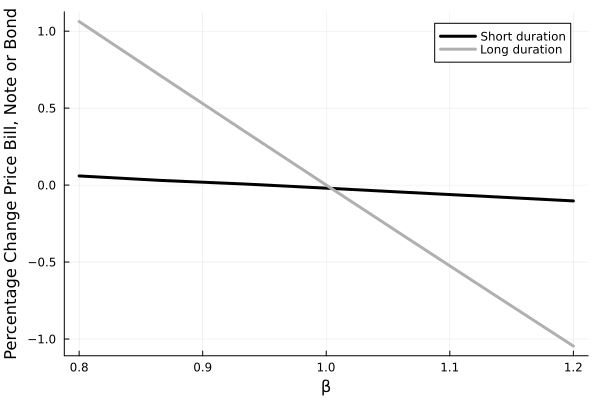

In [17]:
plot(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,2], label="Short duration", lw=3, c=:black, 
        xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")
plot!(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,3], label="Long duration", lw=3, c=:gray69, 
        xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.